## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *


In [3]:
data_folder = '../../data/semantic_drone_dataset/'
path = Path(data_folder)
path.ls()

[PosixPath('../../data/semantic_drone_dataset/models'),
 PosixPath('../../data/semantic_drone_dataset/original_images'),
 PosixPath('../../data/semantic_drone_dataset/class_dict.csv'),
 PosixPath('../../data/semantic_drone_dataset/label_images_semantic')]

In [4]:
path_lbl = path/'label_images_semantic'
path_img = path/'original_images'

## Subset classes

In [5]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('../../data/semantic_drone_dataset/original_images/015.jpg'),
 PosixPath('../../data/semantic_drone_dataset/original_images/002.jpg'),
 PosixPath('../../data/semantic_drone_dataset/original_images/403.jpg')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('../../data/semantic_drone_dataset/label_images_semantic/019.png'),
 PosixPath('../../data/semantic_drone_dataset/label_images_semantic/564.png'),
 PosixPath('../../data/semantic_drone_dataset/label_images_semantic/104.png')]

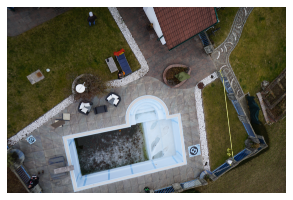

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [9]:
img_f.stem

'015'

In [10]:
get_y_fn = lambda x: path_lbl/f'{x.stem}.png'

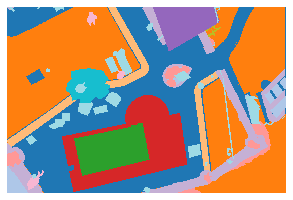

In [11]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [12]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([4000, 6000]),
 tensor([[[3, 1, 1,  ..., 0, 0, 0],
          [3, 1, 1,  ..., 0, 0, 0],
          [3, 1, 1,  ..., 0, 0, 0],
          ...,
          [2, 2, 2,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [15]:
classes_map = pd.read_csv('../../data/semantic_drone_dataset/class_dict.csv')
codes = classes_map.name.tolist()
# codes = ['tree', 'gras', 'other vegetation', 'dirt', 'gravel', 'rocks', 'water', 'paved area', 'pool', 'person', 'dog', 'car', 'bicycle', 'roof', 'wall', 'fence', 'fence-pole', 'window', 'door', 'obstacle']; codes

In [16]:
# codes = [i for i in range(len(codes))]

## Datasets

In [64]:
1/0

ZeroDivisionError: division by zero

In [65]:
size = 256

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 6729MB of GPU RAM free


In [66]:
src = (SegmentationItemList.from_folder(path)
       .split_by_rand_pct(0.1)
       .label_from_func(get_y_fn, classes=codes))

In [67]:
transforms = get_transforms(flip_vert=True, max_zoom=1.05, max_lighting=0.1, max_warp=0.)


In [68]:
data = (src.transform(transforms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

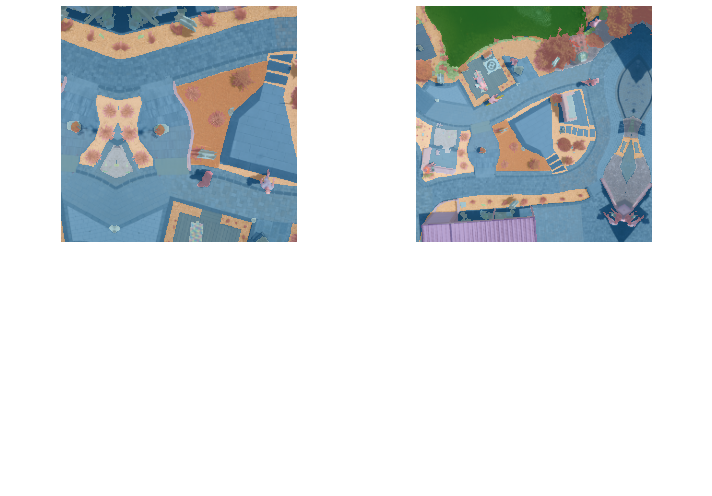

In [55]:
data.show_batch(2, figsize=(10,7))

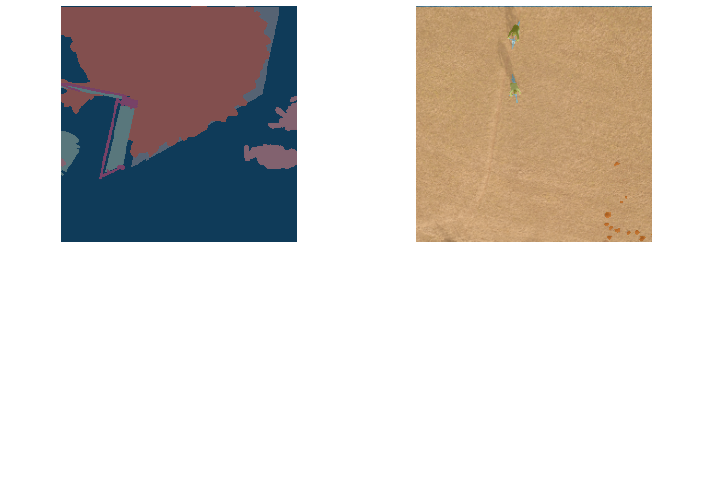

In [56]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [69]:
# One of the two suggested metrics used to evaluate the segmentation dataset
from sklearn.metrics import jaccard_score

def acc_camvid(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

In [70]:
metrics = acc_camvid
# metrics=accuracy

In [71]:
wd=1e-2

In [72]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


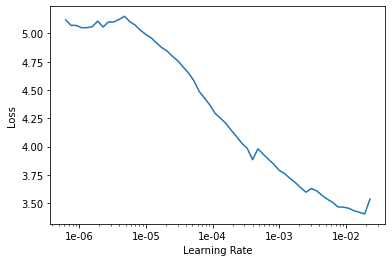

In [61]:
lr_find(learn)
learn.recorder.plot()

In [73]:
lr=1e-3

In [74]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.863681,1.632351,0.439538,02:37
1,1.572282,1.465147,0.509346,02:37
2,1.489272,1.425909,0.603476,02:36
3,1.355670,1.266902,0.569509,02:37
4,1.392600,1.248729,0.547293,02:34
5,1.273294,1.216312,0.606051,02:32
6,1.233847,1.233969,0.620150,02:42
7,1.195476,1.098511,0.608627,02:41
8,1.156895,1.162511,0.623552,02:39
9,0.994037,1.214864,0.639214,02:39


In [75]:
learn.save('stage-1')

In [78]:
learn.load('stage-1');

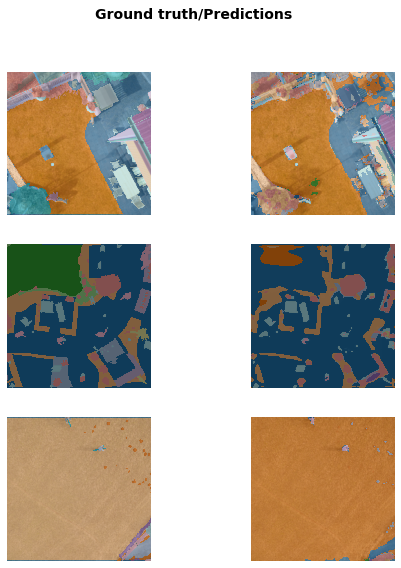

In [79]:
learn.show_results(rows=3, figsize=(8,9))

In [80]:
learn.unfreeze()

In [81]:
lrs = slice(lr/400,lr/4)

In [82]:
learn.fit_one_cycle(10, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.881229,0.881799,0.745107,02:37
1,0.931979,0.880505,0.702912,02:41
2,0.912918,0.826441,0.737265,02:43
3,0.914766,0.819952,0.730388,02:44
4,0.870201,0.758538,0.752831,02:32
5,0.819187,1.123277,0.620957,02:32
6,0.792797,0.745699,0.755514,02:30
7,0.807137,0.796422,0.731729,02:34
8,0.788121,0.738050,0.771656,02:34
9,0.741785,0.698924,0.774491,02:35


In [83]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [84]:
learn.destroy()

size = 480

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=1, have 7234MB of GPU RAM free


In [85]:
data = (src.transform(transforms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [86]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [91]:
learn.load('stage-2');

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


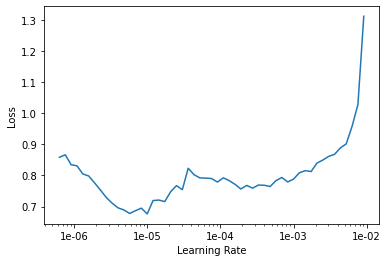

In [95]:
lr_find(learn)
learn.recorder.plot()

In [92]:
lr=3e-5

In [93]:
learn.fit_one_cycle(4, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.963518,1.215222,0.628848,03:43
1,0.812000,1.440922,0.560365,03:44
2,0.781100,1.590665,0.519324,03:49
3,0.761347,1.235710,0.615237,03:50


In [94]:
learn.save('stage-1-big')

In [49]:
learn.load('stage-1-big');

In [96]:
learn.unfreeze()

In [97]:
lrs = slice(1e-6,lr/10)

In [98]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.797494,1.529446,0.518454,04:14
1,0.819038,1.559426,0.520510,04:16
2,0.789593,1.334007,0.594398,04:11
3,0.740451,1.180529,0.611133,04:07
4,0.790194,1.372511,0.595510,04:07
5,0.680506,1.408360,0.580995,04:10
6,0.707638,1.487278,0.579994,04:08
7,0.695992,1.206887,0.629214,04:09
8,0.816641,1.683485,0.510028,04:16
9,0.741347,1.291944,0.593170,04:12


In [47]:
learn.save('stage-2-big')

In [48]:
learn.load('stage-2-big');

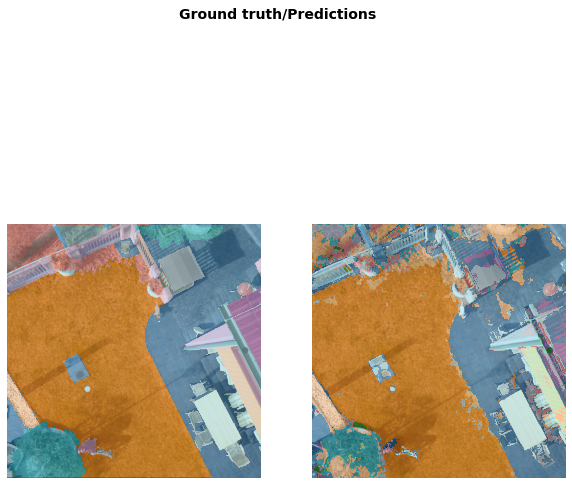

In [99]:
learn.show_results(rows=3, figsize=(10,10))

## fin